<a href="https://colab.research.google.com/gist/Lyken17/91b81526a8245a028d4f85ccc9191884/deep-leakage-from-gradients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
torch.manual_seed(1234)

import random

print(torch.__version__, torchvision.__version__)

1.11.0 0.12.0


In [2]:
tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])
dst = datasets.CIFAR100("~/.torch", download=True, transform=tp)
tt = transforms.ToPILImage()

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

def label_to_onehot(target, num_classes=100):
    target = torch.unsqueeze(target, -1) # input target here is different from the paper
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def batch_cross_entropy_for_onehot(pred, target):
    print("pred: ", pred)
    print("target length: ", len(target), "item size: ", target[0].size())
    total_loss = 0
    for i in range(len(target)):
        total_loss += torch.mean(torch.sum(- target[i] * F.log_softmax(pred[i], dim=-1), 1))
    return total_loss/len(target)

Files already downloaded and verified
Running on cpu


In [3]:
from matplotlib.cbook import flatten


def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)
    
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 100)
        )
        
    def forward(self, x):
        out = self.body(x)
        out = out.view(-1, 768)
        out = self.fc(out)
        return out
    
net = LeNet().to(device)
    
net.apply(weights_init)
criterion = nn.CrossEntropyLoss()

In [4]:
def get_batch(batch_size): 
    # return two tensors data and label, each with length batch_size
    loader = DataLoader(dataset=dst, batch_size=batch_size, shuffle=True)
    it = iter(loader)
    data, label = next(it)
    
    plt.figure(figsize=(12, 8))
    # plt.title("Ground truth image")
    
    for i in range(len(label)):
        # data[i] = data[i].view(1, *data[i].size())
        # label[i] = label[i].long().to(device)
        # label[i] = label[i].view(1, )
        # gt_labels.append(label[i])
        
        #print("data ", i, ": ", data[i].size())


        plt.imshow(tt(data[i].cpu()))
        plt.subplot(5, 10, i+1)
        plt.title("Label %d" % label[i] )
        plt.axis('off')
        
        #print("GT label is %d." % label[i], "\nOnehot label is %d." % torch.argmax(gt_onehot[i], dim=-1).item())

    return data, label

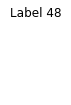

In [5]:
dt, lb = get_batch(1)

In [6]:
lb

tensor([48])

In [7]:
print(dt.size())

torch.Size([1, 3, 32, 32])


In [8]:
out = net(dt)

In [9]:
print(lb.size())

torch.Size([1])


In [10]:
print(out.size())
print(lb.size())

torch.Size([1, 100])
torch.Size([1])


In [11]:
y = criterion(out, lb)
print(y)

tensor(10.8548, grad_fn=<NllLossBackward0>)


In [12]:
# compute original gradient 
dy_dx = torch.autograd.grad(y, net.parameters())
# share the gradients with other clients
original_dy_dx = list((_.detach().clone() for _ in dy_dx))

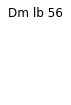

In [13]:
# generate dummy data and label
dummy_data = []
dummy_labels = []
plt.figure(figsize=(12, 8))
for i in range(len(lb)):
    dm_dt = torch.randn(dt[i].size()).to(device).requires_grad_(True)
    # print(dm_dt.is_leaf)
    dummy_data.append(dm_dt)
    dummy_labels.append(torch.randn(1, 100).to(device).requires_grad_(True))
    plt.imshow(tt(dummy_data[i].cpu()))
    plt.subplot(5, 10, i+1)
    plt.title("Dm lb %d" % torch.argmax(dummy_labels[i], dim=-1).item())
    plt.axis('off')

# dummy_data and dummy_labels are lists of tensors here, rather than tensor because calling torch.stack makes them non-leaf

In [14]:
dummy_labels[0].size()

torch.Size([1, 100])

In [15]:
def predict(data_list):
    pred_list = []
    for data in data_list:
        pred = net(data)
        pred_list.append(pred)
    return pred_list        

In [16]:
def batch_crossentropy(pred_list, label_list):
    total_loss = 0
    if (len(pred_list) != len(label_list)):
        print("len(pred_list) != len(label_list)!!")
    for i in range(len(pred_list)):
        total_loss += criterion(pred_list[i], label_list[i])
    return total_loss/len(label_list)

In [17]:
pred = predict(dummy_data)
print(pred[0])

tensor([[  4.6944,  -3.9279,   3.9998,  -2.4000,  -0.5471,   0.5755,   7.0997,
          -1.7615,  -4.6936,  -0.2503,  -5.4461,   6.4821,   1.5447,   2.6552,
          -0.8675,  -4.2255,   4.3316,   5.8028,  -5.4797,   3.9386,   2.1058,
          -0.0560,  -0.6010,  11.8331,   0.9289,  -2.2533,  -2.6453,  -1.1797,
          -2.1892,   0.4024,   0.5274,   2.2666,   8.3795,  -1.3529,   4.0929,
          -2.6544,  -1.6429,  -0.8588,   5.9302,   0.2269,  -8.0848,   4.5370,
          -0.3381,  -1.5715,   6.2124,   2.6167,  -8.9705,  -4.9076,   1.3990,
          -3.2766,   1.4899, -11.4934,   0.9611,  -1.5331,   2.9564,  -2.4012,
           8.8013,  -4.2326,   3.4121,  -0.7214,   3.3484,   5.1597,  -4.0046,
          -2.9405,  -2.9037,  -5.2016,  -1.2473,   2.9026,  -7.8002,  -0.0578,
          -2.6569,   3.3517,  -1.3983,   3.5408,  -3.1030,  -9.1952,   6.3617,
          11.2571,   7.5240,   5.4934,  -1.0689,  -1.8231,   4.3902,   2.2013,
          -9.9026,  -6.7368,  -4.2510,   1.8157,   0

In [18]:

history = []
for i in range(1): 
        optimizer = torch.optim.LBFGS([dummy_data[i], dummy_labels[i]]) # we are only optimizing one single image at a time
        history.append([])
        for iters in range(2000):
            def closure():
                optimizer.zero_grad()

                pred_list =  predict(dummy_data)
                
                # print("dummy pred size: ", len(pred))
                # print("pred: ", pred)
                # print("dummy label size: ", dummy_ts_labels.size())
                dummy_loss = batch_crossentropy(pred_list, dummy_labels)

                dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
                
                grad_diff = 0
                grad_count = 0
                for gx, gy in zip(dummy_dy_dx, original_dy_dx): # TODO: fix the variablas here
                    grad_diff += ((gx - gy) ** 2).sum()
                    grad_count += gx.nelement()
                # grad_diff = grad_diff / grad_count * 1000
                grad_diff.backward()
                
                return grad_diff
            
            optimizer.step(closure)
            if iters % 10 == 0: 
                current_loss = closure()
                print(iters, "%.4f" % current_loss.item())
            history[i].append(tt(dummy_data[i].cpu()))

0 84.7019
10 12.3655
20 6.7024
30 4.6700
40 3.6772
50 3.0118
60 2.5449
70 2.1792
80 1.8928
90 1.6580
100 1.4603
110 1.2801
120 1.1457
130 1.0340
140 0.9260
150 0.8206
160 0.7373
170 0.6566
180 0.5752
190 0.5056
200 0.4533
210 0.4071
220 0.3607
230 0.3205
240 0.2853
250 0.2577
260 0.2298


KeyboardInterrupt: 

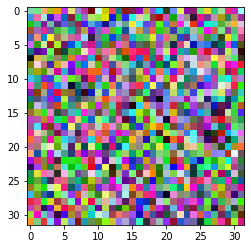

In [ ]:
plt.imshow(history[1][1999])

Dummy label is 56.


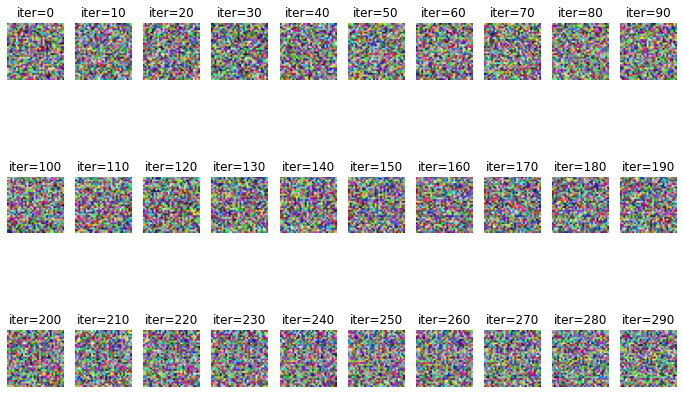

In [ ]:
plt.figure(figsize=(12, 8))

for i in range(30):
  plt.subplot(3, 10, i + 1)
  plt.imshow(history[0][i * 10])
  plt.title("iter=%d" % (i * 10))
  plt.axis('off')
print("Dummy label is %d." % torch.argmax(dummy_labels[0], dim=-1).item())